# HUK-Coding Challenge


__Contents__

1. Data Analysis
2. Modelbuilding
3. Evaluation


## Loading the Data and Project Paths

In [18]:
import pandas as pd
import os
from huk_challenge.config import ProjectPaths

In [19]:

train = pd.read_csv(os.path.join(ProjectPaths.data, "training.csv"), header=None)
vali = pd.read_csv(os.path.join(ProjectPaths.data, "validation.csv"), header=None)
vali.columns = ["id","topic", "sentiment", "text"]
train.columns = ["id", "topic", "sentiment", "text"]
vali.head()

,id,topic,sentiment,text
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


## 1. Explorative Analysis

This __analysis explores the training dataset__. 

__Validation dataset will be treated as it is an unknown dataset__, since we will just evaluate the performance on it. We will only preprocess the individual strings we receive from the validation dataset.


In [20]:
print(f"Training examples: {train.shape[0]}")
print(f"Validation examples: {vali.shape[0]}")

Training examples: 74682
Validation examples: 1000


<Axes: xlabel='sentiment', ylabel='count'>

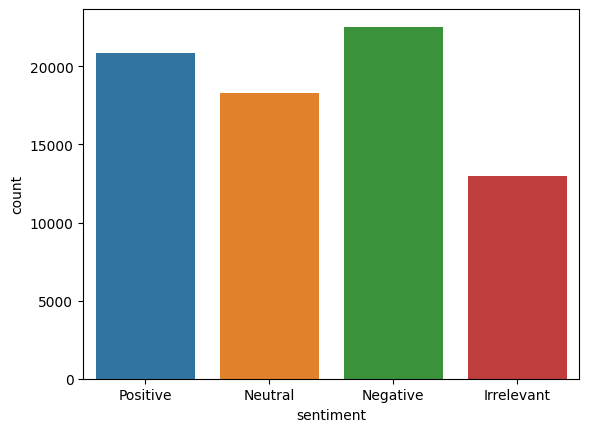

In [21]:
import seaborn as sns

sns.countplot(train, x="sentiment")

### Filter empty entries

In [22]:
filtered_train = train.loc[~train["text"].isna(),:]
print(f"Training examples: {filtered_train.shape[0]}")

Training examples: 73996


In [23]:
filtered_train.loc[filtered_train["text"] == "", :]

,id,topic,sentiment,text


### Filter Meaningless Entries

__meaningless__ = entries, that are either stopwords or to short to convey a message

In [24]:
filtered_train.loc[filtered_train["text"].apply(lambda x: len(x) == 3), :]

,id,topic,sentiment,text
11,2402,Borderlands,Positive,was
53,2409,Borderlands,Neutral,all
191,2432,Borderlands,Positive,why
455,2476,Borderlands,Positive,one
467,2478,Borderlands,Positive,can
...,...,...,...,...
74369,9144,Nvidia,Negative,the
74387,9147,Nvidia,Positive,and
74393,9148,Nvidia,Neutral,the
74507,9171,Nvidia,Neutral,You


* Texts with minor lengths do not seem to have relevant content
* Sentiments are not in line with used words

--> Exclude them from the training set

I checked for more lengths and decided to exclude everything below, a meaningful length of 3, as __words like "Wow" already indicate a positive sentiment__. However there are still words which are not meaningful.

In [25]:
filtered_train = filtered_train.loc[filtered_train["text"].apply(lambda x: len(x) > 2), :]

#### Stopword Removal (Entries)

* To get rid of more meaningless words, one option is to exclude stopwords. I used nltks list of __english stopwords__ and filtered the dataset for it.

In [26]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords


def remove_stops(tweet):
    tweet = tweet.lower()
    stops = set(stopwords.words('english'))
    val = True
    if tweet in stops:
        val = False
    return val

filtered_train = filtered_train.loc[filtered_train["text"].apply(remove_stops), :]
print(f"Training examples: {filtered_train.shape[0]}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elysias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training examples: 72612


Lets compare that, with our previous useless words:

We see that __mostly positive sentiments expressed by "Wow" seem to remain__.
However here we may run into a data leackage problem, as "Wow" is then trained for __multiple times__, which might not change much and the word may be given to much weight. We therefore need to make sure to need __unique entries__.

In [27]:
filtered_train.loc[filtered_train["text"].apply(lambda x: len(x) == 3), :]

,id,topic,sentiment,text
455,2476,Borderlands,Positive,one
2094,2767,Borderlands,Positive,Wow
2095,2767,Borderlands,Positive,Wow
2096,2767,Borderlands,Positive,Wow
2097,2767,Borderlands,Positive,Wow
...,...,...,...,...
72426,8808,Nvidia,Positive,Wow
72427,8808,Nvidia,Positive,Wow
72428,8808,Nvidia,Positive,Wow
72429,8808,Nvidia,Positive,Wow


Looks way better now!

### Drop Duplicates

* Wow occures multiple times
* we want to avoid bias through data leackage -> therefore we drop all duplicates


In [28]:
filtered_train = filtered_train.drop_duplicates(subset="text")
print(f"Training examples: {filtered_train.shape[0]}")

Training examples: 69397


### Check Language

* I would check for the language at that point
* Execution time on my local machine is too long - therefore I skipped this part

-> It is also reasonable to check language before performing inference.

In [29]:
# from langdetect import detect
# from langdetect import LangDetectException


# def detect_lang(tweet):
#     try:
#         language = detect(tweet.lower())
#     except LangDetectException:
#         language = tweet
#     return language

# languages = filtered_train["text"].apply(lambda x: detect_lang(x))
# set(languages)

### ID Field

* The provided ID field could either indicate __users__ or __subtopics__
* Identical IDs always talk about a similar topic and subtopic
* Same ID tweets are always very similar, but not identical

--> Playing with them around in the sentiment classification might give variying results, in our current approach we will include all statements from similar IDs

In [30]:
filtered_train.loc[filtered_train["id"] == 2475, ["sentiment", "text"]].to_dict()

{'sentiment': {444: 'Positive',
  445: 'Positive',
  446: 'Positive',
  447: 'Positive',
  448: 'Positive',
  449: 'Positive'},
 'text': {444: 'Just officiated a gay wedding in Borderlands 3, feeling powerful rn.',
  445: 'I just celebrated a gay wedding in Borderlands 3 and felt powerful.',
  446: 'Just played a gay wedding in Borderlands 3, feeling powerful.',
  447: 'Just officiated a gay wedding in Borderlands 3, the powerful rn.',
  448: 'Just officiated a gay fan wedding in WWE Borderlands Episode 3, feeling powerful rn.',
  449: 'once officiated a gay wedding in Borderlands 3, as powerful rn.'}}

### Class balance after filtering

<Axes: xlabel='sentiment', ylabel='count'>

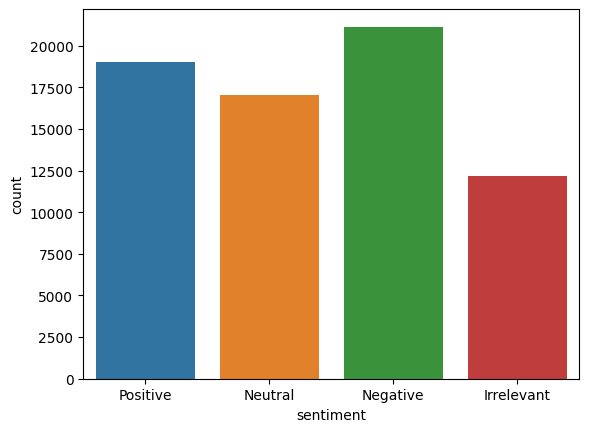

In [31]:
sns.countplot(filtered_train, x="sentiment")

In [32]:
irrelevant = train.loc[train["sentiment"] == "Irrelevant", "text"]
irrelevant.iloc[22]

'I\'m in fact this entire @CBP video. @DHS_Wolf deceptively cut these parts of our report :.. The [UNK] before saying " this is ripping into Arizona and... the rest side of the borderlands in two. ". [UNK] admittedly surveilling us on public road after violent clashes began with Indigenous American activists over protesting wall.'

Looking through a few of the examples marked as _irrelevant_ they do seem __irrelevant for the sentiment__. Therefore these examples will be __excluded from training__.
However a __robust Sentiment Classification model should be able to detect, when some examples are out of distribution__ - meaning they are not part of the distribution the model was trained on. There is variety of literature ob that including some previous publications I worked on. For now entries marked as _irrelevant_ in the training set will simply be excluded.


Publication Example: [Bounding open space risk with decoupling autoencoders in open set recognition](https://link.springer.com/article/10.1007/s41060-022-00342-z)

 - Also known as "Out of Distribution Detection"

Reasons why we exclude irrelevants:

* We can not label everything that is incomming as irrelevant, in a productive case
* Irrelevant entries capture a way broader variety of words, than relevant once. Traning sets not included in _irrlevant_ in the worst case than be detected as relevant -> the better way to go here is to adjust model estimates for robustness to detect irrelevant entries via poor estimates


Entities, seem to be marked wth "@" symbols.


In [33]:
irr_filtered_train = filtered_train.loc[train["sentiment"] != "Irrelevant",:]
irr_vali = vali.loc[vali["sentiment"] != "Irrelevant", :]
print(f"Training examples: {filtered_train.shape[0]}")
print(f"Validation examples: {vali.shape[0]}")

Training examples: 69397
Validation examples: 1000



### Further Options for Analysis:

* Plot Word Embeddings, with the Langauge Model we are going to use and get an impression for the difficulty
* Identify Edges of the given Training classes --> Which instances are very similar to others?

This can also be performed in an ex post analysis, when investigating the probability predictions of the model.

## 2. Modelbuilding

### Preprocessing

Each Tweet contains:

* Emojis
* Links
* A lot of Punctuation in some cases
* Twitter Entities

Apart from that we have to perform:

* Stopword removal
* Tokenization
* Lemmatization - we treat this as optional
* Normalization

I wrote a [Preprocessor Class](/huk_challenge/model.py) to perform the respective work for that.

We also need a ```Language Model``` to transform sentences into the numerical domain. We will use:

* [Glove](https://nlp.stanford.edu/pubs/glove.pdf)
* Mean Pooling of Tokens per Sentence

### Training

* train set was prepared, we will use a random forest classifier to detect the sentiment

Why random forest:

* very simple, but introduces non-linearity
* fast trainig and few parameters
* robust due to ensemble approach
* easy to apply via sci-kit learn

In [34]:
from huk_challenge.model import SKSentimentModel
from sklearn.ensemble import RandomForestClassifier

model = SKSentimentModel(model=RandomForestClassifier(n_estimators=20, criterion="entropy"))
model.train(irr_filtered_train["text"].to_list(), irr_filtered_train["sentiment"].to_list())

/home/elysias/Desktop/repos/huk_challenge/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/elysias/Desktop/repos/huk_challenge/.venv/lib/python3.9/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/elysias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/elysias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Preprocessing finished!
Model training finished!


## 3. Evaluation

In order to evaluate our model we have to find an approiate measure. As we have a classification case, we are going to use a confusion matrix.

Before we start here some explanations:

|Metric|Description|
|------|-----------|
|Precision| Indicates how often statements of a model are correct.|
|Recall| Measures how often a model finds all instances of a particular sentiment|
|F1-Score| Gives the harmonic mean of recall and precision, and thus the performance of the model if both metrics are equally balanced|
|Accuracy| The average over correctly classified instances and all validation instances|
|Support| The number of instances|
|Macro| Support of the respective classes is not respected in the metric|
|Weighted|Metrics are weighted with the support of the respective class|

In [35]:
from sklearn.metrics import classification_report

targets = []
predictions = []
prediction_mapping = {
    -1: "Negative",
    0: "Neutral",
    1: "Positive"
}
for idx, row in irr_vali.iterrows():
    prediction = model.predict(row["text"])
    predictions.append(prediction_mapping.get(prediction))
    if not prediction_mapping.get(prediction):
        print(prediction)
    targets.append(row["sentiment"])
    
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

    Negative       0.84      0.92      0.88       266
     Neutral       0.86      0.82      0.84       285
    Positive       0.88      0.84      0.86       277

    accuracy                           0.86       828
   macro avg       0.86      0.86      0.86       828
weighted avg       0.86      0.86      0.86       828



We reached an macro F1-Score of above 0.8, which can serve as a good baseline for future models.

## Further Steps

1. Analysis

* Analyse the difficulty of the problem, by visualizing embeddings of different language models, via a PCA or UMAP
* Check the probability estimates for _irrelevant_ cases and see, whether there are significantly different from the classes included - if not introduce means for callibration - for ensemble models, more estimators can help in the beginning

2. Optimizing performance

* Hyperparameter Optimization with e.g. Optuna, Raytune, Katib or other tools
* Change to a more complex classification model (e.g. MLP, SVM, or even a transformer if desperatly needed)
* change to a Context aware language model (e.g. ELMO, BERT, or other Transformer based models)

3. Productive Deployment

* Write it as a service via Flask
* Since the model runs majorly on CPU: dockerize it with a python base image - use some orchestration tool (e.g. Docker Compose, Kubernetes) to deploy it
* Other alternatives are also MLOps tools like Kubeflow, Ray, etc.

### Irrelevant Model

For Completion we also include a model with _irrelevant_ as a class.


In [36]:
model_2 = SKSentimentModel(model=RandomForestClassifier(n_estimators=20, criterion="entropy"))
model_2.train(filtered_train["text"].to_list(), filtered_train["sentiment"].to_list())

69397it [01:03, 1092.12it/s]


Preprocessing finished!
Model training finished!


In [37]:
targets = []
predictions = []
prediction_mapping = {
    -1: "Negative",
    0: "Neutral",
    1: "Positive",
    99: "Irrelevant"
}
for idx, row in vali.iterrows():
    prediction = model_2.predict(row["text"])
    predictions.append(prediction_mapping.get(prediction))
    targets.append(row["sentiment"])
    
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

  Irrelevant       0.87      0.73      0.79       172
    Negative       0.77      0.90      0.83       266
     Neutral       0.81      0.79      0.80       285
    Positive       0.81      0.79      0.80       277

    accuracy                           0.81      1000
   macro avg       0.82      0.80      0.81      1000
weighted avg       0.81      0.81      0.81      1000



We see a slight decrease in performance, whereas Irrelevant entries are the worst performing onces. Also we had lower number of instances for these entries.

I would still rather favour an approach where we classify only the sentiment and go for model robustness, enabeling us to use model estimates for identifiying irrelevant entries. As irrelevant entries can come in all shapes or forms and thus we may run into an distributional shift issue.